In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import svgpathtools
from svgpathtools import Line, Path, svg2paths, wsvg, disvg
import numpy as np
import matplotlib.pyplot as plt
import math
import cvxpy as cp
import scipy
import scipy.ndimage
from track import Track
from tire import fiala_tire_model, fiala_lookup

plt.style.use('seaborn')

# Parameters

In [3]:
# SEGMENT_LENGTH = 0.05  # in meters
SEGMENT_LENGTH = 0.05
BOUNDARY_SEGMENT_LENGTH = 0.01 # in meters, finer 
TRACK_WIDTH = 1.3
ROBOT_HALF_WIDTH = 0.17 # includes safety padding
G = 9.807

ROBOT_MASS = 1.457 # kg
ROBOT_LF = 0.128
ROBOT_LR = 0.137
ROBOT_I = 0.0965

MIU = 0.8
TOP_SPEED = 11

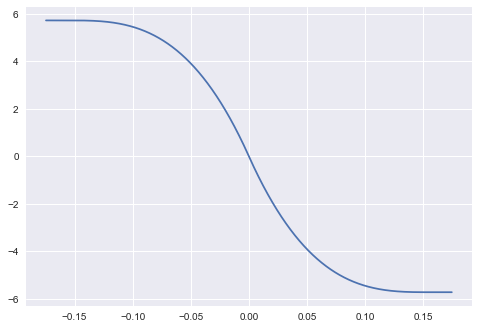

In [4]:
Fz = ROBOT_MASS*G/2
C = MIU*Fz / np.radians(3)  # semi nonsense value.
alpha, force = fiala_tire_model(Fz, MIU, C)

plt.figure()
plt.plot(alpha, force)
plt.show()

# Create Initial Offset Sketch

In [110]:
# construct offset curves for track boundaries

paths, attrs = svg2paths(r'c:\tmp\car\track2.svg')
path = paths[0]

def offset_curve(path, offset_distance, steps=1000):
    """Takes in a Path object, `path`, and a distance,
    `offset_distance`, and outputs an piecewise-linear approximation 
    of the 'parallel' offset curve."""
    nls = []
    for seg in path:
        for k in range(steps):
            t = k / steps
            offset_vector = offset_distance * seg.normal(t)
            nl = Line(seg.point(t), seg.point(t) + offset_vector)
            nls.append(nl)
    connect_the_dots = [Line(nls[k].end, nls[k+1].end) for k in range(len(nls)-1)]
    if path.isclosed():
        connect_the_dots.append(Line(nls[-1].end, nls[0].end))
    offset_path = Path(*connect_the_dots)
    return offset_path

left_boundary = offset_curve(path, 650.0, steps=5)
right_boundary = offset_curve(path, -650.0, steps=5)

disvg([path, left_boundary, right_boundary], 'brg', filename=r'c:\tmp\car\test_boundaries.svg')


# Load Final Track Model

Racing path length is  42.10087106666157


c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][842]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][842]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


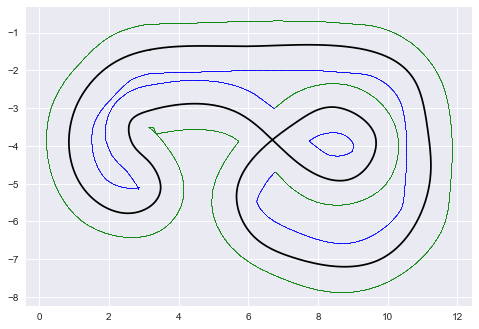

In [28]:
paths, attrs = svg2paths(r'c:\tmp\car\test_out.svg')
racing_path = paths[0]
left_boundary = paths[1]
right_boundary = paths[2]

print("Racing path length is ", racing_path.length() / 1000)

def make_pts(path, segment_length):
  L = path.length()
  steps = int(L / (segment_length * 1000))
  tpts = [path.ilength(L*k/steps) for k in range(steps)]
  pts = [path.point(t) / 1000 for t in tpts]
  # SVG y-axis is reversed
  return [[p.real for p in pts], [-p.imag for p in pts]]

track = Track()
track.racing_line_from_points(make_pts(racing_path, SEGMENT_LENGTH), smooth_factor=1)
track.set_left_boundary(make_pts(left_boundary, BOUNDARY_SEGMENT_LENGTH))
track.set_right_boundary(make_pts(right_boundary, BOUNDARY_SEGMENT_LENGTH))

track.display()

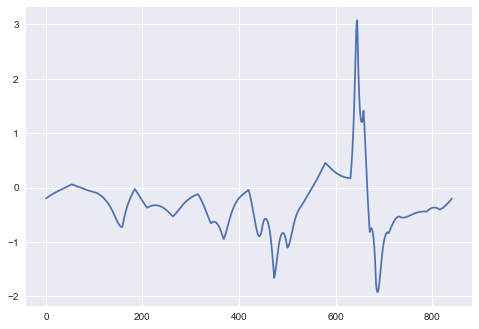

In [29]:
plt.figure()
plt.plot([*range(len(track.K))], track.K)
plt.show()

# Optimize

## Velocity

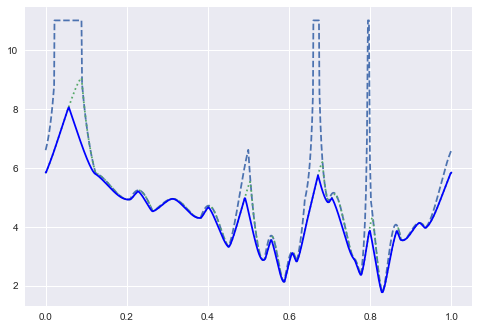

In [37]:
V = []  # hello! kitty loves bear

for Ks in track.K:
  Vs = TOP_SPEED
  if abs(Ks) > 0.1:
    Vs = min(TOP_SPEED, math.sqrt(MIU*G/abs(Ks)))
  V.append(Vs)

plt.figure()
plt.plot(track.u, V, '--')

def max_a(v, k):
  f_residual = (MIU*G)**2 - (v**2*k)**2
  if f_residual > 0:
    return math.sqrt(f_residual)
  return 0.0

# could have tried to start at np.argmin(V), but just loop twice to make
# handling the looparound easier
for i in range(2):
  for idx in range(1, len(V)):
    prev_idx = idx - 1
    prev_v = V[prev_idx]
    prev_k = track.K[prev_idx]
    a = max_a(prev_v, prev_k)
    force_constrained = math.sqrt(prev_v**2 + 2*a*track.S[prev_idx])
    V[idx] = min(V[idx], force_constrained)
  V[0] = V[-1]

plt.plot(track.u, V, ':')

for i in range(2):
  for idx in range(len(V)-2, -1, -1):
    next_idx = idx + 1
    next_v = V[next_idx]
    next_k = track.K[next_idx]
    a = max_a(next_v, next_k)
    force_constrained = math.sqrt(next_v**2 + 2*a*track.S[next_idx])
    V[idx] = min(V[idx], force_constrained)
  V[-1] = V[0]

plt.plot(track.u, V, '-b')
plt.show()

## Path

In [38]:
def c2d(dt, A, B, D):
  ar, ac = A.shape
  assert B.shape == (ar,1)
  assert D.shape == (ar,1)
  X = dt * np.concatenate((A, B, D), axis=1)
  r, c = X.shape
  X = np.concatenate((X, np.zeros((c-r, c))))
  Xt = scipy.linalg.expm(X)

  return Xt[0:ar,0:ac], Xt[0:ar,ac], Xt[0:ar,ac+1]


left_dists, right_dists = track.boundary_dist(ROBOT_HALF_WIDTH)

N = len(V)
x = cp.Variable((5, N)) # [e delta_heading yaw_rate beta heading]
# slack = cp.Variable(5)
delta = cp.Variable(N)
constraints = [
  x[0,0] == 0,
  x[0,:] <= left_dists,
  -1.0*x[0,:] <= right_dists,
  cp.abs(x[0:4,0] - x[0:4,-1]) <= 0.0001,
]

for idx in range(N-1):
  s = track.S[idx] if idx > 0 else track.S[-1]
  dt = s/V[idx]
  A = np.zeros((5, 5), dtype=np.float64)
  # assumes even weight dstro.. should fix?
  Fyf = ROBOT_MASS/2*track.K[idx]*V[idx]**2
  Fyr = Fyf
  slip_front, Cf = fiala_lookup(alpha, force, Fyf)
  slip_rear, Cr = fiala_lookup(alpha, force, Fyr)
  A[0,1] = V[idx]
  A[0,3] = V[idx]
  A[1,2] = 1.0
  A[2,2] = (-(ROBOT_LF**2)*Cf-(ROBOT_LR**2)*Cr)/(V[idx]*ROBOT_I)
  A[2,3] = (ROBOT_LR*Cr-ROBOT_LF*Cf)/ROBOT_I
  A[3,2] = (ROBOT_LR*Cr-ROBOT_LF*Cf)/(ROBOT_MASS*V[idx]**2) - 1
  A[3,3] = (-Cf-Cr)/(ROBOT_MASS*V[idx])
  A[4,2] = 1.0
  B = np.array([0.0, 0.0, ROBOT_LF * Cf / ROBOT_I, Cf / (ROBOT_MASS * V[idx]), 0]).reshape((5,1))
  D = np.array([
    0.0,
    -track.K[idx]*V[idx],
    (ROBOT_LF*Cf*slip_front - ROBOT_LR*Cr*slip_rear + ROBOT_LF*Fyf - ROBOT_LR*Fyr)/ROBOT_I,
    (Cf*slip_front + Cr*slip_rear + Fyf + Fyr)/(ROBOT_MASS*V[idx]),
    0.0
  ]).reshape((5,1))
  Ak, Bk, Dk = c2d(dt, A,B,D)
  constraints.append(x[:,idx+1] == Ak@x[:,idx] + Bk*delta[idx] + Dk)

# obj = cp.Minimize(cp.sum_squares(cp.diff(x[4,:])/np.diff(S)) + 0.01*cp.sum_squares(cp.diff(delta)) + 500000*cp.norm(slack, p=2))
obj = cp.Minimize(cp.sum_squares(cp.diff(x[4,:])/track.S[1:]) + 1.0*cp.sum_squares(cp.diff(delta)))

prob = cp.Problem(obj, constraints)
prob.solve()

print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value 235.16004655741204


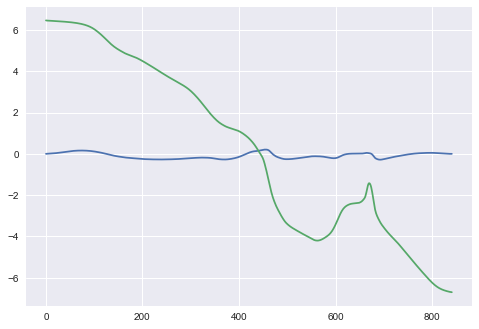

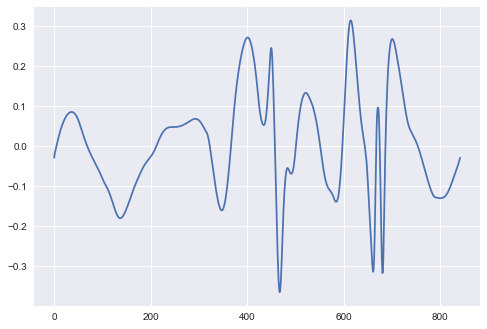

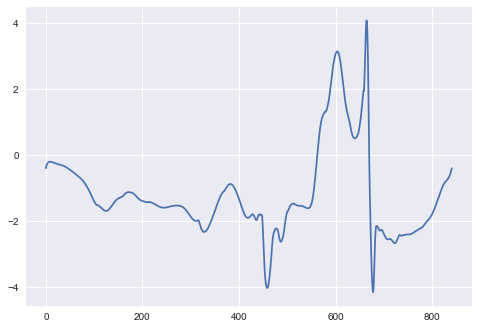

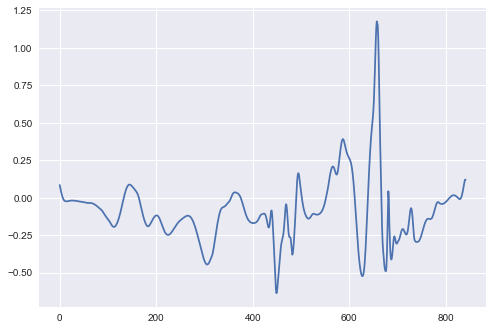

In [39]:
plt.figure()
xaxis = [x for x in range(842)]
plt.plot(xaxis, x.value[0,:], xaxis, x.value[4,:])
plt.show()
plt.figure()
plt.plot(xaxis, x.value[1,:])
plt.show()
plt.figure()
plt.plot(xaxis, x.value[2,:])
plt.show()
plt.figure()
plt.plot(xaxis, delta.value)
plt.show()

c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][842]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][842]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


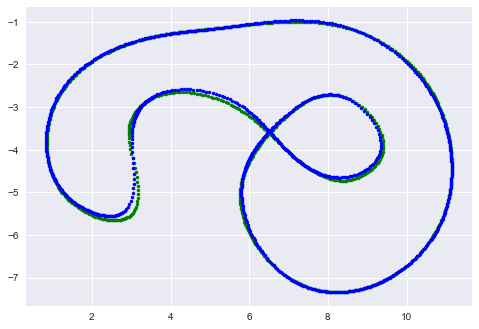

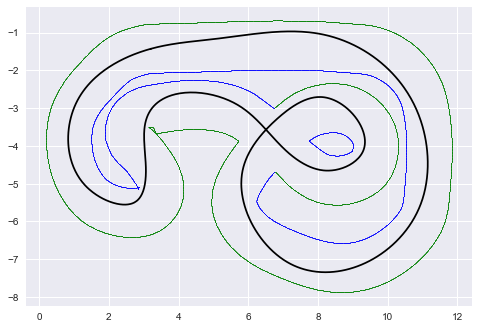

In [40]:
plt.figure()
plt.plot(track.pts[0], track.pts[1],'.g')

new_x = []
new_y = []
for idx in range(len(track.pts[0])):
  xp, yp = track.pts[0][idx], track.pts[1][idx]
  xstar = x.value[:,idx]
  new_x.append(xp - xstar[0]*math.cos(xstar[4]))
  new_y.append(yp - xstar[0]*math.sin(xstar[4]))

track.racing_line_from_points([new_x, new_y], smooth_factor=1)
plt.plot(track.pts[0], track.pts[1],'.b')

plt.show()

track.display()